# Processing gravimetric capacity data

In [1]:
%matplotlib inline

In [2]:
import os
import glob
import pandas as pd
import numpy as np
from numpy import median
import matplotlib.pyplot as plt
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

Set the folder to import text files from:

In [3]:
path = r'C:\Users\laure\Dropbox\DATA\SCap\(0-0-1)(10-0)T'
#path = r'C:\Users\laure\Dropbox\DATA\SCap\(0-0-1)(10-0)P'

Import the files into a numpy array

In [4]:
allfiles = glob.glob(os.path.join(path, "*.txt"))
data_imp = (pd.read_csv(f, delimiter='\t', header='infer') for f in allfiles)
rawimp = np.asarray(pd.concat(data_imp))

Identify the lengths of each sample set:

In [5]:
sl = []                             # Initialise variable for sample length
for i in range(len(rawimp)):        
    if rawimp[i, 0]==1:             # Look for cycle number 1 (in 0th column)
        sl.append(i)                # Record row numbers of new cycles ending

sl.append(len(rawimp))              # Append total length of rawimp data set

sle = np.zeros(shape=(len(sl)-1), dtype=int)        # Initialise variable for storing row ranges for each sample
for i in range(len(sl)-1):                          
    sle[i] = sl[i+1]-sl[i]                          # Subtract sample ends from sl to obtain lengths of sample data sets

Initialise empty numpy array with enough rows for the sample with the most rows...
    4 columns (all samples have Cycle, Charge, Discharge, Efficiency by default)...
    enough layers for each sample (corresponds to number of values in sle)

In [6]:
data = np.empty(shape=(max(sle), 4, len(sle)), dtype=object)
discharge = np.empty(shape=(max(sle), len(sle)), dtype = float)

In [7]:
for i in range(len(sle)):
    data[range(sle[i]), :, i] = rawimp[range(sl[i], sl[i+1]), :]

In [8]:
for i in range(max(sle)):
    for j in range(len(sle)):
        discharge[i, j] = data[i, 2, j]

## Making plot

In [9]:
plotdat = discharge[:, 2]

In [10]:
cycles = range(len(discharge))
lastcyc = (~np.isnan(plotdat)).cumsum(0).argmax(0)

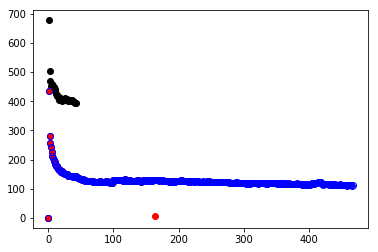

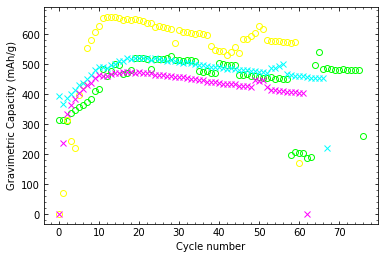

In [11]:
ax = plt.figure(1)

sample1 = plt.plot(cycles, discharge[:, 0], ls='None', marker='o', color=[0, 0, 0])
# sample2 = plt.plot(cycles, discharge[:, 1], ls='None', marker='o', color='red')
sample3 = plt.plot(cycles, discharge[:, 2], ls='None', marker='o', color=[1, 0, 0])
sample7 = plt.plot(cycles, discharge[:, 6], ls='None', marker='o', fillstyle = 'none', color=[0, 0, 1])

# sample5 = plt.plot(cycles, discharge[:, 4], ls='None', marker='x', fillstyle = 'none', color='cyan')
# sample6 = plt.plot(cycles, discharge[:, 5], ls='None', marker='x', fillstyle = 'none', color='blue')

ax = plt.figure(2)
sample4 = plt.plot(cycles, discharge[:, 3], ls='None', marker='o', fillstyle = 'none', color=[0, 1, 0])
sample8 = plt.plot(cycles, discharge[:, 7], ls='None', marker='o', fillstyle = 'none', color=[1, 1, 0])
sample9 = plt.plot(cycles, discharge[:, 8], ls='None', marker='x', fillstyle = 'none', color=[0, 1, 1])
sample10 = plt.plot(cycles, discharge[:, 9], ls='None', marker='x', fillstyle = 'none', color=[1, 0, 1])

plt.xlabel('Cycle number')
plt.ylabel('Gravimetric Capacity (mAh/g)')
plt.tick_params(axis='y', which='both', direction='in', labelright=False, right=True)
plt.minorticks_on()
plt.tick_params(which='both', direction='in', right=True, left=True, bottom=True, top=True)
# plt.legend()


## Finding stable capacity

In [12]:
discharge[:, :]

array([[0.00, 0.00, 0.00, ..., 0.00, 393.10, 0.00],
       [677.80, 157.70, 434.10, ..., 70.00, 369.10, 238.30],
       [504.90, 66.40, 282.50, ..., 314.20, 386.00, 334.50],
       ...,
       [nan, 23.10, nan, ..., nan, nan, nan],
       [nan, 22.50, nan, ..., nan, nan, nan],
       [nan, 23.20, nan, ..., nan, nan, nan]])

In [13]:
tol = 2

In [14]:
grad_range = 1
d2dx2_range = 5

In [15]:
if grad_range == 1:
    cap_change_end = 2
else:
    cap_change_end = grad_range

    
if d2dx2_range == 1:
    cap_change2_end = 2
else:
    cap_change2_end = d2dx2_range
    

In [16]:
cap_change = np.zeros(shape=discharge.shape, dtype=float)
for j in range(cap_change.shape[1]):
    for i in range(1, cap_change.shape[0]-cap_change_end):
        cap_change[i, j] = (discharge[i+grad_range, j] - discharge[i, j])/grad_range
        cap_change[-cap_change_end:cap_change.shape[0]] = np.nan

In [17]:
cap_change_2 = np.zeros(shape=discharge.shape, dtype=float)
for j in range(cap_change_2.shape[1]):
    for i in range(1, cap_change_2.shape[0]-cap_change2_end):
        cap_change_2[i, j] = np.sum(cap_change[i:i+d2dx2_range, j])/d2dx2_range
        cap_change_2[-cap_change2_end:cap_change_2.shape[0]] = np.nan

In [18]:
J = 3

In [19]:
plateau = np.full(cap_change_2.shape, np.nan)
a = abs(cap_change_2[3-J:3+J, 0])
if all(v<100 for v in a):
    print('yes')

yes


In [20]:
a

array([0.00, 44.24, 10.22, 4.48, 0.88, 3.18])

In [21]:
tol_measure = np.zeros(shape = cap_change_2.shape)
# a = np.zeros(shape=(cap_change_2.shape[0], 6))
for j in range(cap_change_2.shape[1]):
    for i in range(J, cap_change_2.shape[0]-J):
        a = abs(cap_change_2[i-J:i+J, j])
        if all(val < tol for val in a):
            tol_measure[i, j] = 1

In [22]:
plat_start = np.zeros(shape=(tol_measure.shape[1], 1), dtype=float)
for j in range(tol_measure.shape[1]):
    try:
        np.nonzero(tol_measure[:, j])[0][0]
    except:
        plat_start[j, 0] = np.nan
    else:
        plat_start[j, 0] = np.nonzero(tol_measure[:, j])[0][0]

In [23]:
plat_start

array([[20.00],
       [9.00],
       [19.00],
       [nan],
       [20.00],
       [9.00],
       [19.00],
       [14.00],
       [20.00],
       [16.00]])

In [24]:
stable_discharge = np.zeros(shape=(tol_measure.shape[1], 1), dtype=float)
for j in range(tol_measure.shape[1]):
    try:
        discharge[int(plat_start[j][0]), j]
    except:
        stable_discharge[j] = np.nan
    else:
        stable_discharge[j] = discharge[int(plat_start[j][0]), j] 

In [25]:
stable_discharge

array([[403.00],
       [45.70],
       [159.10],
       [nan],
       [403.00],
       [45.70],
       [159.10],
       [656.50],
       [522.00],
       [473.60]])

In [26]:
stable_discharge = stable_discharge[~np.isnan(stable_discharge).any(axis=1)]

In [27]:
np.mean(stable_discharge)

318.6333333333333

In [28]:
np.std(stable_discharge)

209.13817867089162

In [29]:
np.median(stable_discharge)

403.0